In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
f = open('data/ner_bio.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence=[]
        continue
    splits = line.split(' ')
    splits[-1] = re.sub(r'\n', '', splits[-1])
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

In [3]:
print("전체 샘플 개수:", len(tagged_sentences))

전체 샘플 개수: 14041


In [4]:
tagged_sentences[:1]

[[['eu', 'B-ORG'],
  ['rejects', 'O'],
  ['german', 'B-MISC'],
  ['call', 'O'],
  ['to', 'O'],
  ['boycott', 'O'],
  ['british', 'B-MISC'],
  ['lamb', 'O'],
  ['.', 'O']]]

In [5]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [6]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887329962253


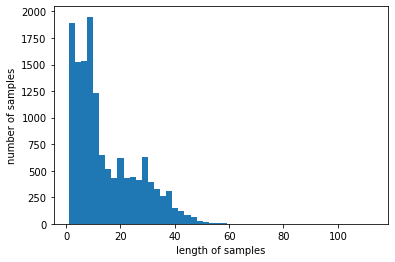

In [7]:
print('샘플의 최대 길이 :',max(len(l) for l in sentences))
print('샘플의 평균 길이 :',sum(map(len, sentences))/len(sentences))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer=Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [9]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 :',vocab_size)
print('개체명 태킹 정보 집합의 크기 :',tag_size)

단어 집합의 크기 : 4000
개체명 태킹 정보 집합의 크기 : 10


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [11]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [12]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [13]:
decoded = []
for index in X_train[0]:
    decoded.append(index_to_word[index])
    
print('기존 문장:',sentences[0])
print('빈도수가 낮은 단어가 oov 처리 된문장:',decoded)

기존 문장: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 oov 처리 된문장: ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [14]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [16]:
y_train

array([[4, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [2, 8, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [17]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [20]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                   output_dim = 128,
                   input_length = max_len,
                   mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, batch_size = 128, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 40s 457ms/step - loss: 0.1859 - accuracy: 0.8251 - val_loss: 0.1253 - val_accuracy: 0.8333
Epoch 2/8
88/88 [==============================] - 38s 430ms/step - loss: 0.1013 - accuracy: 0.8526 - val_loss: 0.0794 - val_accuracy: 0.8826
Epoch 3/8
88/88 [==============================] - 38s 435ms/step - loss: 0.0696 - accuracy: 0.9000 - val_loss: 0.0566 - val_accuracy: 0.9200
Epoch 4/8
88/88 [==============================] - 38s 432ms/step - loss: 0.0503 - accuracy: 0.9299 - val_loss: 0.0442 - val_accuracy: 0.9394
Epoch 5/8
88/88 [==============================] - 37s 423ms/step - loss: 0.0386 - accuracy: 0.9466 - val_loss: 0.0380 - val_accuracy: 0.9467
Epoch 6/8
88/88 [==============================] - 37s 422ms/step - loss: 0.0323 - accuracy: 0.9543 - val_loss: 0.0359 - val_accuracy: 0.9501
Epoch 7/8
88/88 [==============================] - 37s 423ms/step - loss: 0.0276 - accuracy: 0.9607 - val_loss: 0.0329 - val_accuracy: 0.9547
Epoch 

In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 5s 52ms/step - loss: 0.0329 - accuracy: 0.9558

 테스트 정확도: 0.9558


In [24]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  O
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
presiden